#**DS ASSIGNMENT**

---


###Data Description:
###file format:
####train.parquet
####test.parquet
####sample_submission.csv
####final_submission.csv


###Health records of patients diagnosed with a certain disease are present in both train and test files, various categories of health records like diseases diagnosis, tests, symptoms, and drug treatments are captured in the records along with the date of occurrence for each patient.

--> Patient-Uid: Unique Identifier for each patient

--> Date: Date on which the patient encountered the event

--> Incident: Actual event encountered

--> Total Number of unique patients present in train.parquet 27K


An event called “Target Drug ” is present in the incident column of the training set for around 9K patients at least once in their journey.

###Datalink: https://drive.google.com/file/d/1oHnw-M9jOshB3WkbKrMBWepjlEHAdwA1/view

###Problem Statment:

###1. Drugs are developed in therapeutic areas to boost the patients’ condition against chronic and terminally ill diseases, the “Target Drug” is one such and it can boost the patients’ health without making them dependent on the other drugs that can lead to life-threatening side effects.

###The objective is to build a predictive model to estimate if a patient is eligible for the first prescription of the “Target Drug” in the next 30 days so that the physician who is treating the patient could be informed on the better treatment choices.

###A. Come up with the right strategies to create positive and negative data samples from the data(avoid any biases while sampling the data to build a good predictive model)


###B. Build a predictive model by doing the appropriate feature engineering(eg:
frequency-based, time-based features, e.t.c). The predictive model could also
leverage Deep Learning based techniques.

###C. Evaluate the model on your own validation set and come up with the right
threshold to minimize false positives and false negatives
DS ASSIGNMENT


###D. Some of the patients present in the test file are eligible for the drug prescription within a month and some of them are not, using each patient’s historical data predict if he/she is eligible for the “Target Drug”


###E. Each patient-uid should be labeled with a binary value of 1 or 0 using the built model, 1 is considered as eligible for the “Target Drug” in the next 30 days and 0 considered as un-eligible


###F. Submit the final_submission.csv file by filling the predicted label for each patient in the “label” column, make sure you don’t change the format, file name, and the order of patients to be consistent with evaluating algorithm(refer sample_submission.csv).


###G. The evaluation metric for the assignment is F1-Score(candidates with the highest F1 score would be prioritized)


###*** Note ipython notebooks should be submitted along with the results by documenting the assumptions/process along the way(better documentation is also given weightage in the final score) and make sure the results are reproducible within an acceptable range of standard deviation


###2. Drugs are administered to patients in certain patterns to get the best outcome, but for various reasons, patients drop off early without finishing the regimen. Assume that the patients are required to stay on the “Target drug” for as long as one year, come up with your own analysis using different visualization techniques on how the drop off rate is present each month after the first prescription is made and what are the events contributing to the drop-off Should submit the ipython notebooks along with visualizations with some text describing your insights


###3. A drug could be administered to patients in different patterns. From the data, extract dominant patterns in which the “Target Drug” is being administered across the patients using clustering techniques.


###Visualize the prescription patterns with time on X-axis and prescriptions on Y-axis for each of the patterns you are able to extract(following is an example of a prescription pattern, where a prescription is made at least once in the first two months followed by one prescription for every two months)


######Should submit the ipython notebooks along with code and visualizations of prescription patterns



##Submission guidelines:

###1. Submissions for questions 2 and 3 are considered only if the results for question 1 are uploaded.

###2. Results should be reproducible and the code should be re-runnable.

###3. The assignment will be evaluated for 15 points, 10 points for problem statement 1, 3 points for problem statement 3, and 2 points for problem statement 2

###4. Uploading code Maintain separate Jupyter notebooks for each of the problem statements, and naming convection for the Jupyter notebooks should be as below

####a. 001.ipynb ==>problem statement 1

####b. 002.ipynb ==>problem statement 2

####c. 003.ipynb ==>problem statement 3


###Note: You can create multiple notebooks for a single problem statement, example 001.1.ipynb Use the following convection for documenting the process, steps and results.


####a. 001.pdf ==>problem statement 1

####b. 002.pdf ==>problem statement 2

####c. 002.pdf ==>problem statement 3


##Note: You can also describe what more could be done if you have more time Package all the files in a zip format and name it in the following structure and upload it in the allocated field in the google form “yourname_structureddata_solution.zip“

###5. Uploading results 

###Problem statement 1 -upload the final_submission.csv to the google form in the allocated field and we will consider 001.ipynb and 001.pdf

###Problem statement 2- we will consider 002.ipynb and 002.pdf

###Problem statement 3- we will consider 003.ipynb and 003.pdf


In [1]:
from google.colab import drive
drive.mount('/content/drive.')

Mounted at /content/drive.


In [2]:
!pip install pyarrow.parquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pyarrow.parquet (from versions: none)
ERROR: No matching distribution found for pyarrow.parquet


In [138]:
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
import itertools as it

from copy import deepcopy
%matplotlib inline

import pandas as pd # handle the data
from sklearn.model_selection import train_test_split # split the data

from sklearn import metrics # evaluation metrics
import seaborn as sns # plotting the data
import matplotlib.pyplot as plt # plotting the data

from sklearn.metrics import accuracy_score, plot_roc_curve, roc_curve, roc_auc_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [4]:
df = pq.read_table(source='/content/drive./MyDrive/Akaike/Structured Data Assignment/train.parquet').to_pandas()
df1 = pq.read_table(source='/content/drive./MyDrive/Akaike/Structured Data Assignment/test.parquet').to_pandas()

#Convert them into pandas DataFrame as df

In [5]:
df = pd.DataFrame(df)
df1 = pd.DataFrame(df1)

In [6]:
df

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


In [7]:
df = pd.get_dummies(df, columns=['Incident'])

In [8]:
df.shape, df1.shape

((3220868, 59), (1065524, 3))

##Checking the null values

In [9]:
df.isnull().sum(), df1.isnull().sum()

(Patient-Uid                   0
 Date                          0
 Incident_DRUG_TYPE_0          0
 Incident_DRUG_TYPE_1          0
 Incident_DRUG_TYPE_10         0
 Incident_DRUG_TYPE_11         0
 Incident_DRUG_TYPE_12         0
 Incident_DRUG_TYPE_13         0
 Incident_DRUG_TYPE_14         0
 Incident_DRUG_TYPE_15         0
 Incident_DRUG_TYPE_16         0
 Incident_DRUG_TYPE_17         0
 Incident_DRUG_TYPE_18         0
 Incident_DRUG_TYPE_2          0
 Incident_DRUG_TYPE_3          0
 Incident_DRUG_TYPE_4          0
 Incident_DRUG_TYPE_5          0
 Incident_DRUG_TYPE_6          0
 Incident_DRUG_TYPE_7          0
 Incident_DRUG_TYPE_8          0
 Incident_DRUG_TYPE_9          0
 Incident_PRIMARY_DIAGNOSIS    0
 Incident_SYMPTOM_TYPE_0       0
 Incident_SYMPTOM_TYPE_1       0
 Incident_SYMPTOM_TYPE_10      0
 Incident_SYMPTOM_TYPE_11      0
 Incident_SYMPTOM_TYPE_12      0
 Incident_SYMPTOM_TYPE_13      0
 Incident_SYMPTOM_TYPE_14      0
 Incident_SYMPTOM_TYPE_15      0
 Incident_

#Dropping the duplicates

In [10]:
df = df.drop_duplicates(); df1 = df1.drop_duplicates()

In [11]:
df.shape, df.shape

((3185297, 59), (3185297, 59))

#Here some different between before shape of the dropped duplicates and after the dropped duplicates shaps.

Counting the unique values

In [12]:
df.nunique()

Patient-Uid                   27033
Date                           1977
Incident_DRUG_TYPE_0              2
Incident_DRUG_TYPE_1              2
Incident_DRUG_TYPE_10             2
Incident_DRUG_TYPE_11             2
Incident_DRUG_TYPE_12             2
Incident_DRUG_TYPE_13             2
Incident_DRUG_TYPE_14             2
Incident_DRUG_TYPE_15             2
Incident_DRUG_TYPE_16             2
Incident_DRUG_TYPE_17             2
Incident_DRUG_TYPE_18             2
Incident_DRUG_TYPE_2              2
Incident_DRUG_TYPE_3              2
Incident_DRUG_TYPE_4              2
Incident_DRUG_TYPE_5              2
Incident_DRUG_TYPE_6              2
Incident_DRUG_TYPE_7              2
Incident_DRUG_TYPE_8              2
Incident_DRUG_TYPE_9              2
Incident_PRIMARY_DIAGNOSIS        2
Incident_SYMPTOM_TYPE_0           2
Incident_SYMPTOM_TYPE_1           2
Incident_SYMPTOM_TYPE_10          2
Incident_SYMPTOM_TYPE_11          2
Incident_SYMPTOM_TYPE_12          2
Incident_SYMPTOM_TYPE_13    

#Checking the Datatypes in the given data

In [13]:
df.dtypes, df1.dtypes

(Patient-Uid                           object
 Date                          datetime64[ns]
 Incident_DRUG_TYPE_0                   uint8
 Incident_DRUG_TYPE_1                   uint8
 Incident_DRUG_TYPE_10                  uint8
 Incident_DRUG_TYPE_11                  uint8
 Incident_DRUG_TYPE_12                  uint8
 Incident_DRUG_TYPE_13                  uint8
 Incident_DRUG_TYPE_14                  uint8
 Incident_DRUG_TYPE_15                  uint8
 Incident_DRUG_TYPE_16                  uint8
 Incident_DRUG_TYPE_17                  uint8
 Incident_DRUG_TYPE_18                  uint8
 Incident_DRUG_TYPE_2                   uint8
 Incident_DRUG_TYPE_3                   uint8
 Incident_DRUG_TYPE_4                   uint8
 Incident_DRUG_TYPE_5                   uint8
 Incident_DRUG_TYPE_6                   uint8
 Incident_DRUG_TYPE_7                   uint8
 Incident_DRUG_TYPE_8                   uint8
 Incident_DRUG_TYPE_9                   uint8
 Incident_PRIMARY_DIAGNOSIS       

#Grouping them in the order of patiend uid and incident

In [14]:
df.groupby('Patient-Uid').max()

,Date,Incident_DRUG_TYPE_0,Incident_DRUG_TYPE_1,Incident_DRUG_TYPE_10,Incident_DRUG_TYPE_11,Incident_DRUG_TYPE_12,Incident_DRUG_TYPE_13,Incident_DRUG_TYPE_14,Incident_DRUG_TYPE_15,Incident_DRUG_TYPE_16,...,Incident_SYMPTOM_TYPE_7,Incident_SYMPTOM_TYPE_8,Incident_SYMPTOM_TYPE_9,Incident_TARGET DRUG,Incident_TEST_TYPE_0,Incident_TEST_TYPE_1,Incident_TEST_TYPE_2,Incident_TEST_TYPE_3,Incident_TEST_TYPE_4,Incident_TEST_TYPE_5
Patient-Uid,,,,,,,,,,,,,,,,,,,,,
a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2020-08-09,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2020-03-29,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2019-04-05,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2020-07-10,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2020-08-12,1,1,0,1,0,0,0,0,0,...,1,1,0,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a0f0d4c5-1c7c-11ec-bfec-16262ee38c7f,2020-08-30,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
a0f0d4f4-1c7c-11ec-b144-16262ee38c7f,2020-08-10,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
a0f0d523-1c7c-11ec-89d2-16262ee38c7f,2020-08-11,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


###Sort them by Date

In [15]:
df.sort_values(by = ['Date'], inplace=True)

In [16]:
df

,Patient-Uid,Date,Incident_DRUG_TYPE_0,Incident_DRUG_TYPE_1,Incident_DRUG_TYPE_10,Incident_DRUG_TYPE_11,Incident_DRUG_TYPE_12,Incident_DRUG_TYPE_13,Incident_DRUG_TYPE_14,Incident_DRUG_TYPE_15,...,Incident_SYMPTOM_TYPE_7,Incident_SYMPTOM_TYPE_8,Incident_SYMPTOM_TYPE_9,Incident_TARGET DRUG,Incident_TEST_TYPE_0,Incident_TEST_TYPE_1,Incident_TEST_TYPE_2,Incident_TEST_TYPE_3,Incident_TEST_TYPE_4,Incident_TEST_TYPE_5
2222167,a0e2d262-1c7c-11ec-93d9-16262ee38c7f,2015-04-07,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2931211,a0e7e340-1c7c-11ec-97ca-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2609406,a0e2bb12-1c7c-11ec-bc94-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2609409,a0e1fd77-1c7c-11ec-a1d2-16262ee38c7f,2015-04-07,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2765911,a0e1fa82-1c7c-11ec-b072-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23132677,a0eb2a57-1c7c-11ec-b755-16262ee38c7f,2020-09-03,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934130,a0ebbc15-1c7c-11ec-b4be-16262ee38c7f,2020-09-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21170875,a0f048fb-1c7c-11ec-82c9-16262ee38c7f,2020-09-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2450641,a0e65375-1c7c-11ec-93c4-16262ee38c7f,2020-09-03,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df.shape

(3185297, 59)

In [ ]:
# # Missing data
# sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


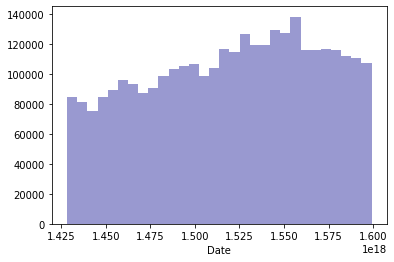

In [18]:
sns.distplot(df['Date'].dropna(), kde=False, color='darkblue', bins=30)

### Filter data between two dates

###Display the filtered data

In [19]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
  
# Filter data between two dates
filtered_df = df.loc[(df['Date'] >= '2020-09-01')
                     & (df['Date'] < '2020-09-15')]
# Display
filtered_df

,Patient-Uid,Date,Incident_DRUG_TYPE_0,Incident_DRUG_TYPE_1,Incident_DRUG_TYPE_10,Incident_DRUG_TYPE_11,Incident_DRUG_TYPE_12,Incident_DRUG_TYPE_13,Incident_DRUG_TYPE_14,Incident_DRUG_TYPE_15,...,Incident_SYMPTOM_TYPE_7,Incident_SYMPTOM_TYPE_8,Incident_SYMPTOM_TYPE_9,Incident_TARGET DRUG,Incident_TEST_TYPE_0,Incident_TEST_TYPE_1,Incident_TEST_TYPE_2,Incident_TEST_TYPE_3,Incident_TEST_TYPE_4,Incident_TEST_TYPE_5
22136434,a0ea1c89-1c7c-11ec-aa53-16262ee38c7f,2020-09-01,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11752125,a0ed8527-1c7c-11ec-97ec-16262ee38c7f,2020-09-01,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688186,a0e1c097-1c7c-11ec-85f6-16262ee38c7f,2020-09-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2491,a0dd3d4b-1c7c-11ec-93d9-16262ee38c7f,2020-09-01,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
809190,a0df610e-1c7c-11ec-a537-16262ee38c7f,2020-09-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23132677,a0eb2a57-1c7c-11ec-b755-16262ee38c7f,2020-09-03,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934130,a0ebbc15-1c7c-11ec-b4be-16262ee38c7f,2020-09-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21170875,a0f048fb-1c7c-11ec-82c9-16262ee38c7f,2020-09-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2450641,a0e65375-1c7c-11ec-93c4-16262ee38c7f,2020-09-03,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
train_data = filtered_df.copy()

In [24]:
b = []
for i in df.keys():
  b.append(i)
print(b)

['Patient-Uid', 'Date', 'Incident_DRUG_TYPE_0', 'Incident_DRUG_TYPE_1', 'Incident_DRUG_TYPE_10', 'Incident_DRUG_TYPE_11', 'Incident_DRUG_TYPE_12', 'Incident_DRUG_TYPE_13', 'Incident_DRUG_TYPE_14', 'Incident_DRUG_TYPE_15', 'Incident_DRUG_TYPE_16', 'Incident_DRUG_TYPE_17', 'Incident_DRUG_TYPE_18', 'Incident_DRUG_TYPE_2', 'Incident_DRUG_TYPE_3', 'Incident_DRUG_TYPE_4', 'Incident_DRUG_TYPE_5', 'Incident_DRUG_TYPE_6', 'Incident_DRUG_TYPE_7', 'Incident_DRUG_TYPE_8', 'Incident_DRUG_TYPE_9', 'Incident_PRIMARY_DIAGNOSIS', 'Incident_SYMPTOM_TYPE_0', 'Incident_SYMPTOM_TYPE_1', 'Incident_SYMPTOM_TYPE_10', 'Incident_SYMPTOM_TYPE_11', 'Incident_SYMPTOM_TYPE_12', 'Incident_SYMPTOM_TYPE_13', 'Incident_SYMPTOM_TYPE_14', 'Incident_SYMPTOM_TYPE_15', 'Incident_SYMPTOM_TYPE_16', 'Incident_SYMPTOM_TYPE_17', 'Incident_SYMPTOM_TYPE_18', 'Incident_SYMPTOM_TYPE_19', 'Incident_SYMPTOM_TYPE_2', 'Incident_SYMPTOM_TYPE_20', 'Incident_SYMPTOM_TYPE_21', 'Incident_SYMPTOM_TYPE_22', 'Incident_SYMPTOM_TYPE_23', 'Inciden

In [26]:
b.remove('Patient-Uid')
b.remove('Date')
print(b)

['Incident_DRUG_TYPE_0', 'Incident_DRUG_TYPE_1', 'Incident_DRUG_TYPE_10', 'Incident_DRUG_TYPE_11', 'Incident_DRUG_TYPE_12', 'Incident_DRUG_TYPE_13', 'Incident_DRUG_TYPE_14', 'Incident_DRUG_TYPE_15', 'Incident_DRUG_TYPE_16', 'Incident_DRUG_TYPE_17', 'Incident_DRUG_TYPE_18', 'Incident_DRUG_TYPE_2', 'Incident_DRUG_TYPE_3', 'Incident_DRUG_TYPE_4', 'Incident_DRUG_TYPE_5', 'Incident_DRUG_TYPE_6', 'Incident_DRUG_TYPE_7', 'Incident_DRUG_TYPE_8', 'Incident_DRUG_TYPE_9', 'Incident_PRIMARY_DIAGNOSIS', 'Incident_SYMPTOM_TYPE_0', 'Incident_SYMPTOM_TYPE_1', 'Incident_SYMPTOM_TYPE_10', 'Incident_SYMPTOM_TYPE_11', 'Incident_SYMPTOM_TYPE_12', 'Incident_SYMPTOM_TYPE_13', 'Incident_SYMPTOM_TYPE_14', 'Incident_SYMPTOM_TYPE_15', 'Incident_SYMPTOM_TYPE_16', 'Incident_SYMPTOM_TYPE_17', 'Incident_SYMPTOM_TYPE_18', 'Incident_SYMPTOM_TYPE_19', 'Incident_SYMPTOM_TYPE_2', 'Incident_SYMPTOM_TYPE_20', 'Incident_SYMPTOM_TYPE_21', 'Incident_SYMPTOM_TYPE_22', 'Incident_SYMPTOM_TYPE_23', 'Incident_SYMPTOM_TYPE_24', 'In

## Array of features

In [27]:
X = df[b].values #array of features
#y = df['Patient-Uid'].values

In [ ]:
df0 = df.iloc[2, :]
df0

In [44]:
df['TARGET_DRUG'] = np.where(df[['Incident_DRUG_TYPE_0', 'Incident_DRUG_TYPE_1', 'Incident_DRUG_TYPE_10', 'Incident_DRUG_TYPE_11', 'Incident_DRUG_TYPE_12', 'Incident_DRUG_TYPE_13', 'Incident_DRUG_TYPE_14', 'Incident_DRUG_TYPE_15', 'Incident_DRUG_TYPE_16', 'Incident_DRUG_TYPE_17', 'Incident_DRUG_TYPE_18', 'Incident_DRUG_TYPE_2', 'Incident_DRUG_TYPE_3', 'Incident_DRUG_TYPE_4', 'Incident_DRUG_TYPE_5', 'Incident_DRUG_TYPE_6', 'Incident_DRUG_TYPE_7', 'Incident_DRUG_TYPE_8', 'Incident_DRUG_TYPE_9', 'Incident_PRIMARY_DIAGNOSIS', 'Incident_SYMPTOM_TYPE_0', 'Incident_SYMPTOM_TYPE_1', 'Incident_SYMPTOM_TYPE_10', 'Incident_SYMPTOM_TYPE_11', 'Incident_SYMPTOM_TYPE_12', 'Incident_SYMPTOM_TYPE_13', 'Incident_SYMPTOM_TYPE_14', 'Incident_SYMPTOM_TYPE_15', 'Incident_SYMPTOM_TYPE_16', 'Incident_SYMPTOM_TYPE_17', 'Incident_SYMPTOM_TYPE_18', 'Incident_SYMPTOM_TYPE_19', 'Incident_SYMPTOM_TYPE_2', 'Incident_SYMPTOM_TYPE_20', 'Incident_SYMPTOM_TYPE_21', 'Incident_SYMPTOM_TYPE_22', 'Incident_SYMPTOM_TYPE_23', 'Incident_SYMPTOM_TYPE_24', 'Incident_SYMPTOM_TYPE_25', 'Incident_SYMPTOM_TYPE_26', 'Incident_SYMPTOM_TYPE_27', 'Incident_SYMPTOM_TYPE_28', 'Incident_SYMPTOM_TYPE_29', 'Incident_SYMPTOM_TYPE_3', 'Incident_SYMPTOM_TYPE_4', 'Incident_SYMPTOM_TYPE_5', 'Incident_SYMPTOM_TYPE_6', 'Incident_SYMPTOM_TYPE_7', 'Incident_SYMPTOM_TYPE_8', 'Incident_SYMPTOM_TYPE_9', 'Incident_TARGET DRUG', 'Incident_TEST_TYPE_0', 'Incident_TEST_TYPE_1', 'Incident_TEST_TYPE_2', 'Incident_TEST_TYPE_3', 'Incident_TEST_TYPE_4', 'Incident_TEST_TYPE_5']] == 1, 0, 1)
df

,Patient-Uid,Date,Incident_DRUG_TYPE_0,Incident_DRUG_TYPE_1,Incident_DRUG_TYPE_10,Incident_DRUG_TYPE_11,Incident_DRUG_TYPE_12,Incident_DRUG_TYPE_13,Incident_DRUG_TYPE_14,Incident_DRUG_TYPE_15,...,Incident_SYMPTOM_TYPE_8,Incident_SYMPTOM_TYPE_9,Incident_TARGET DRUG,Incident_TEST_TYPE_0,Incident_TEST_TYPE_1,Incident_TEST_TYPE_2,Incident_TEST_TYPE_3,Incident_TEST_TYPE_4,Incident_TEST_TYPE_5,TARGET_DRUG
2222167,a0e2d262-1c7c-11ec-93d9-16262ee38c7f,2015-04-07,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2931211,a0e7e340-1c7c-11ec-97ca-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2609406,a0e2bb12-1c7c-11ec-bc94-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2609409,a0e1fd77-1c7c-11ec-a1d2-16262ee38c7f,2015-04-07,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2765911,a0e1fa82-1c7c-11ec-b072-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23132677,a0eb2a57-1c7c-11ec-b755-16262ee38c7f,2020-09-03,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934130,a0ebbc15-1c7c-11ec-b4be-16262ee38c7f,2020-09-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21170875,a0f048fb-1c7c-11ec-82c9-16262ee38c7f,2020-09-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2450641,a0e65375-1c7c-11ec-93c4-16262ee38c7f,2020-09-03,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [46]:
# Viewing the Values of Traget Variable.
df['TARGET_DRUG'].value_counts()

1    2886416
0     298881
Name: TARGET_DRUG, dtype: int64

In [48]:
target_1 = df[df['TARGET_DRUG'] == 1]
target_0 = df[df['TARGET_DRUG'] == 0]

In [49]:
print('Average Target Drug: ' + str(df['TARGET_DRUG'].mean()))
print('Average Taken Target Drug: ' + str(target_1['TARGET_DRUG'].mean()))
print('Average Not taking drug: ' + str(target_0['TARGET_DRUG'].mean()))
print('\n')

Average Target Drug: 0.9061685613617819
Average Taken Target Drug: 1.0
Average Not taking drug: 0.0




In [54]:
# create a list of our conditions
conditions = [
    (df['TARGET_DRUG'] == 1),
    (df['TARGET_DRUG'] != 1)]

# create a list of the values we want to assign for each condition
values = [1, 0]

# create a new column and use np.select to assign values to it using our lists as arguments
df['label'] = np.select(conditions, values)

# display updated DataFrame
df

,Patient-Uid,Date,Incident_DRUG_TYPE_0,Incident_DRUG_TYPE_1,Incident_DRUG_TYPE_10,Incident_DRUG_TYPE_11,Incident_DRUG_TYPE_12,Incident_DRUG_TYPE_13,Incident_DRUG_TYPE_14,Incident_DRUG_TYPE_15,...,Incident_TARGET DRUG,Incident_TEST_TYPE_0,Incident_TEST_TYPE_1,Incident_TEST_TYPE_2,Incident_TEST_TYPE_3,Incident_TEST_TYPE_4,Incident_TEST_TYPE_5,TARGET_DRUG,LABEL,label
2222167,a0e2d262-1c7c-11ec-93d9-16262ee38c7f,2015-04-07,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2931211,a0e7e340-1c7c-11ec-97ca-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2609406,a0e2bb12-1c7c-11ec-bc94-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2609409,a0e1fd77-1c7c-11ec-a1d2-16262ee38c7f,2015-04-07,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2765911,a0e1fa82-1c7c-11ec-b072-16262ee38c7f,2015-04-07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23132677,a0eb2a57-1c7c-11ec-b755-16262ee38c7f,2020-09-03,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3934130,a0ebbc15-1c7c-11ec-b4be-16262ee38c7f,2020-09-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
21170875,a0f048fb-1c7c-11ec-82c9-16262ee38c7f,2020-09-03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2450641,a0e65375-1c7c-11ec-93c4-16262ee38c7f,2020-09-03,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1


In [ ]:
 # Remove columns mentioned in the column name
df_1 = df.drop(['LABEL','Date','TARGET_DRUG'], axis=1)

In [78]:
df_1.shape

(3185297, 59)

In [79]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3185297 entries, 2222167 to 26691229
Data columns (total 59 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   Patient-Uid                 object
 1   Incident_DRUG_TYPE_0        uint8 
 2   Incident_DRUG_TYPE_1        uint8 
 3   Incident_DRUG_TYPE_10       uint8 
 4   Incident_DRUG_TYPE_11       uint8 
 5   Incident_DRUG_TYPE_12       uint8 
 6   Incident_DRUG_TYPE_13       uint8 
 7   Incident_DRUG_TYPE_14       uint8 
 8   Incident_DRUG_TYPE_15       uint8 
 9   Incident_DRUG_TYPE_16       uint8 
 10  Incident_DRUG_TYPE_17       uint8 
 11  Incident_DRUG_TYPE_18       uint8 
 12  Incident_DRUG_TYPE_2        uint8 
 13  Incident_DRUG_TYPE_3        uint8 
 14  Incident_DRUG_TYPE_4        uint8 
 15  Incident_DRUG_TYPE_5        uint8 
 16  Incident_DRUG_TYPE_6        uint8 
 17  Incident_DRUG_TYPE_7        uint8 
 18  Incident_DRUG_TYPE_8        uint8 
 19  Incident_DRUG_TYPE_9        uint8 


In [80]:
train_df = df_1.copy()

In [109]:
X = train_df.drop('Patient-Uid', axis=1)
y = train_df['label']

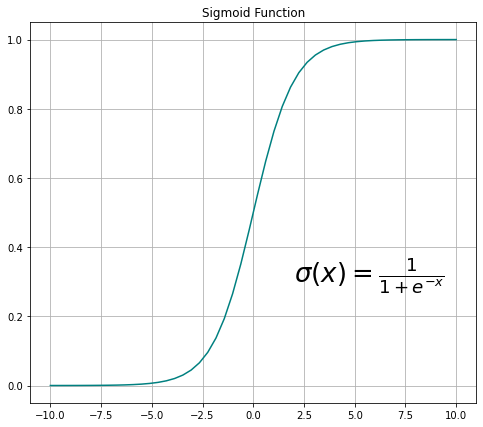

In [110]:

def sigmoid(x):
  return(1/(1 + np.exp(-x)))

x_values_for_sigmoid = np.linspace(-10, 10)
plt.figure(figsize=(8, 7))
plt.plot(x_values_for_sigmoid, sigmoid(x_values_for_sigmoid), c='teal')
plt.title('Sigmoid Function')
plt.grid(True)
plt.text(2, 0.3, r'$\sigma(x)=\frac{1}{1+e^{-x}}$', fontsize=26)
plt.show()

In [111]:
logistic_regression = LogisticRegression() #initialise the required package
logistic_regression.fit(X_train,y_train) #magic happens - best values of betas - training/learning happens here
y_pred = logistic_regression.predict(X_test)

logistic_regression.coef_

array([[-1.06206602e+01,  1.20026718e+00,  1.48210181e-01,
         2.81199347e-01,  7.31018596e-02,  9.21787300e-02,
         1.25164209e-01,  3.88538229e-02,  9.28934110e-03,
         1.85313032e-03,  0.00000000e+00,  8.76334458e-01,
         5.82129456e-01,  3.65547677e-02,  3.29892649e-01,
         1.26854334e+00,  8.66882538e-01,  6.68345342e-01,
         3.76386626e-01,  1.12927288e+00,  2.84136259e-01,
         6.59370926e-02,  4.69421690e-02,  1.99570056e-02,
         2.09043068e-02,  1.27256293e-02,  6.79738699e-02,
         4.94714573e-02,  3.89081760e-02,  1.70702138e-02,
         4.36369806e-03,  1.78288498e-03,  6.30428997e-02,
         4.81543325e-04,  2.94065978e-03,  2.27439304e-03,
         4.46324350e-04,  7.28005918e-04,  1.52735269e-04,
         5.40236041e-04,  1.17492858e-04,  8.22479333e-05,
         4.70812338e-02,  3.16162436e-02,  3.28059161e-02,
         5.85138039e-02,  2.12456499e-01,  1.54565776e-01,
         5.83359862e-02,  3.87668457e-02,  3.77287384e-0

In [112]:
logistic_regression.predict_proba(X_test)

array([[4.93231511e-06, 9.99995068e-01],
       [3.30074862e-06, 9.99996699e-01],
       [8.04781407e-06, 9.99991952e-01],
       ...,
       [4.93231511e-06, 9.99995068e-01],
       [3.53398182e-06, 9.99996466e-01],
       [4.93231511e-06, 9.99995068e-01]])

In [113]:
logistic_regression.coef_

array([[-1.06206602e+01,  1.20026718e+00,  1.48210181e-01,
         2.81199347e-01,  7.31018596e-02,  9.21787300e-02,
         1.25164209e-01,  3.88538229e-02,  9.28934110e-03,
         1.85313032e-03,  0.00000000e+00,  8.76334458e-01,
         5.82129456e-01,  3.65547677e-02,  3.29892649e-01,
         1.26854334e+00,  8.66882538e-01,  6.68345342e-01,
         3.76386626e-01,  1.12927288e+00,  2.84136259e-01,
         6.59370926e-02,  4.69421690e-02,  1.99570056e-02,
         2.09043068e-02,  1.27256293e-02,  6.79738699e-02,
         4.94714573e-02,  3.89081760e-02,  1.70702138e-02,
         4.36369806e-03,  1.78288498e-03,  6.30428997e-02,
         4.81543325e-04,  2.94065978e-03,  2.27439304e-03,
         4.46324350e-04,  7.28005918e-04,  1.52735269e-04,
         5.40236041e-04,  1.17492858e-04,  8.22479333e-05,
         4.70812338e-02,  3.16162436e-02,  3.28059161e-02,
         5.85138039e-02,  2.12456499e-01,  1.54565776e-01,
         5.83359862e-02,  3.87668457e-02,  3.77287384e-0

In [114]:
logistic_regression.intercept_

array([0.7321316])

###Evaluation

In [117]:
logistic_regression.score(X_test,y_test) # accuracy

1.0

In [118]:
confusion_matrix(y_test,y_pred)

array([[ 89611,      0],
       [     0, 865979]])

In [122]:
f1_score(y_test,y_pred)

1.0

In [119]:
logistic_regression.score(X_test,y_test)

1.0

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


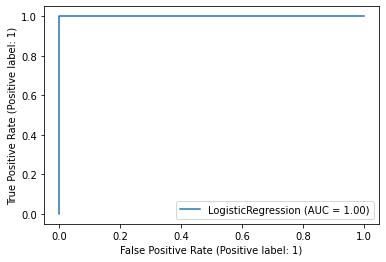

In [120]:
plot_roc_curve(logistic_regression, X_test, y_test)

In [121]:
accuracy_score(y_test, y_pred)

1.0

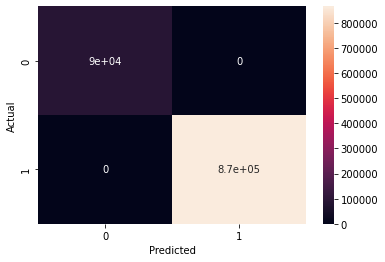

In [124]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

###Evaluate The Predection

####We predicted the test results and now we will evaluate if our logistic regression model learned and understood correctly. 

####So this confusion matrix is going to contain the correct predictions that our model made on the set as well as the incorrect predictions.

In [128]:
train_df.head()

,Patient-Uid,Incident_DRUG_TYPE_0,Incident_DRUG_TYPE_1,Incident_DRUG_TYPE_10,Incident_DRUG_TYPE_11,Incident_DRUG_TYPE_12,Incident_DRUG_TYPE_13,Incident_DRUG_TYPE_14,Incident_DRUG_TYPE_15,Incident_DRUG_TYPE_16,...,Incident_SYMPTOM_TYPE_8,Incident_SYMPTOM_TYPE_9,Incident_TARGET DRUG,Incident_TEST_TYPE_0,Incident_TEST_TYPE_1,Incident_TEST_TYPE_2,Incident_TEST_TYPE_3,Incident_TEST_TYPE_4,Incident_TEST_TYPE_5,label
2222167,a0e2d262-1c7c-11ec-93d9-16262ee38c7f,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2931211,a0e7e340-1c7c-11ec-97ca-16262ee38c7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2609406,a0e2bb12-1c7c-11ec-bc94-16262ee38c7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2609409,a0e1fd77-1c7c-11ec-a1d2-16262ee38c7f,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2765911,a0e1fa82-1c7c-11ec-b072-16262ee38c7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [144]:
# Remove all columns between column name 'B' to 'D'
df_1 = df_1.drop(df_1.loc[:, 'Incident_DRUG_TYPE_0':'Incident_TEST_TYPE_5'].columns, axis=1)

In [145]:
df_1

,Patient-Uid,label
2222167,a0e2d262-1c7c-11ec-93d9-16262ee38c7f,1
2931211,a0e7e340-1c7c-11ec-97ca-16262ee38c7f,1
2609406,a0e2bb12-1c7c-11ec-bc94-16262ee38c7f,1
2609409,a0e1fd77-1c7c-11ec-a1d2-16262ee38c7f,1
2765911,a0e1fa82-1c7c-11ec-b072-16262ee38c7f,1
...,...,...
23132677,a0eb2a57-1c7c-11ec-b755-16262ee38c7f,0
3934130,a0ebbc15-1c7c-11ec-b4be-16262ee38c7f,1
21170875,a0f048fb-1c7c-11ec-82c9-16262ee38c7f,1
2450641,a0e65375-1c7c-11ec-93c4-16262ee38c7f,1


###Get the output file as a csv format

In [146]:
df_1.to_csv("/content/drive./MyDrive/Akaike/Structured Data Assignment/final_submission.csv")

In [147]:
df_1

,Patient-Uid,label
2222167,a0e2d262-1c7c-11ec-93d9-16262ee38c7f,1
2931211,a0e7e340-1c7c-11ec-97ca-16262ee38c7f,1
2609406,a0e2bb12-1c7c-11ec-bc94-16262ee38c7f,1
2609409,a0e1fd77-1c7c-11ec-a1d2-16262ee38c7f,1
2765911,a0e1fa82-1c7c-11ec-b072-16262ee38c7f,1
...,...,...
23132677,a0eb2a57-1c7c-11ec-b755-16262ee38c7f,0
3934130,a0ebbc15-1c7c-11ec-b4be-16262ee38c7f,1
21170875,a0f048fb-1c7c-11ec-82c9-16262ee38c7f,1
2450641,a0e65375-1c7c-11ec-93c4-16262ee38c7f,1
